# Run PEST and Parallel PEST
### This should be super easy ~

In [1]:
import os
import shutil
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;
import psutil
import sys
import pyemu
import swatp_pst
assert "dependencies" in pyemu.__file__
assert "dependencies" in swatp_pst.__file__

# 01. Specify a path to the model folder

In [2]:
# path to project directory
prj_dir = "C:\\Mac\\Home\\Documents\\projects" # win
# prj_dir = "/Users/seonggyu.park/Documents/projects/jj" #mac

In [3]:
main_opt_path = os.path.join(prj_dir, 'main_opt')
os.chdir(main_opt_path)

In [4]:
os.getcwd()

'C:\\Mac\\Home\\Documents\\projects\\main_opt'

# 02. Initial run for adjusting weights

In [5]:
# PEST control file name
pst_name = "swatp_dummy.pst"

In [14]:
# initial run
pyemu.os_utils.run(f'pestpp-glm.exe {pst_name}' , cwd=".")

pestpp-glm.exe swatp_dummy.pst


## 02-01 Change weights to make all of observation data visible 

In [15]:
# reweight
pst = pyemu.Pst(pst_name)
pst.phi

np.float64(100956.33226360545)

In [17]:
# you can assign any values to balanced phi value for each group
balanced_groups = {grp:1000 for grp in pst.nnz_obs_groups}
pst.adjust_weights(obsgrp_dict=balanced_groups)

In [25]:
pst_rw = "swatp_rw.pst"

In [26]:
# Let's create a new control file with the number of iterations set to 30 and incorporate reweighted factors.
pst.control_data.noptmax = 0
pst.write(os.path.join(main_opt_path, f'{pst_rw}'), version=2)

noptmax:0, npar_adj:201, nnz_obs:755


In [27]:
pyemu.os_utils.run(f'pestpp-glm.exe {pst_rw}' , cwd=".")

pestpp-glm.exe swatp_rw.pst


# 03. Perform uncertainty analysis with IES

In [21]:
# check the number of available cores
num_workers = psutil.cpu_count(logical=False)
num_workers

4

In [22]:
main_opt_path

'C:\\Mac\\Home\\Documents\\projects\\main_opt'

In [28]:
pst_nam_ies = "swatp_rw_ies.pst"

In [21]:
pst_ies = pyemu.Pst(os.path.join(main_opt_path, f"{pst_rw}"))
# set IES
pst_ies.pestpp_options['ies_num_reals'] = 200 # number of realization
pst_ies.control_data.noptmax = 15 # number of iteration
pst_ies.write(f'{pst_nam_ies}', version=2) # write new IES control file

noptmax:15, npar_adj:13, nnz_obs:167


In [22]:
# set a path to the main directory of model
m_d = os.path.join(prj_dir, "swatp_rw_ies")

In [23]:
m_d

'D:\\spark\\Albufera\\opt01\\alb_rw_ies'

In [25]:
main_opt_path

'D:\\spark\\Albufera\\opt01\\main_opt'

In [24]:
prj_dir

'D:\\spark\\Albufera\\opt01'

In [27]:
os.chdir(prj_dir) # move the loction to project directory
# run PEST in parallel
pyemu.os_utils.start_workers(
                            main_opt_path, # the folder which contains the "template" PEST dataset
                            "pestpp-ies", #the PEST software version we want to run
                            f'{pst_nam_ies}', # the control file to use with PEST
                            num_workers=num_workers, #how many agents to deploy
                            worker_root='.', #where to deploy the agent directories; relative to where python is running
                            master_dir=m_d, #the manager directory,
                            # reuse_master=True
                            )

# 03. Let's see how we did:

In [1]:
from swatp_pst import analyzer
import pyemu
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

D:\spark\spark_gits\swatp_pst_wf\dependencies\pyemu\pyemu\__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


In [2]:
m_d = 'D:\\spark\\Albufera\\opt01\\alb_rw_ies02'

In [3]:
pst_file = "alb_rw_ies.pst"
pst = pyemu.Pst(os.path.join(m_d, pst_file))

### 03.01 phi progress

In [ ]:
pst.phi

In [33]:
# plot phi progress
# pyemu.plot_utils.phi_progress(pst)

In [5]:
pst_file = "alb_rw_ies.pst"
pst = pyemu.Pst(os.path.join(m_d, pst_file))

In [6]:
# load prior simulation
pr_oe = pyemu.ObservationEnsemble.from_csv(
    pst=pst,filename=os.path.join(m_d,"alb_rw_ies.0.obs.csv")
    )
# load posterior simulation
pt_oe = pyemu.ObservationEnsemble.from_csv(
    pst=pst,
    filename=os.path.join(m_d,"alb_rw_ies.{0}.obs.csv".format(8))
    )

In [7]:
pt_oe

return type uncaught, losing Ensemble type, returning DataFrame


D:\spark\spark_gits\swatp_pst_wf\dependencies\pyemu\pyemu\en.py:227: PyemuWarning: return type uncaught, losing Ensemble type, returning DataFrame


,cha049_20170511,cha049_20170512,cha049_20170513,cha049_20170514,cha049_20170515,cha049_20170516,cha049_20170517,cha049_20170518,cha049_20170519,cha049_20170520,...,obd_irr_paddy_20220531,obd_irr_paddy_20220630,obd_irr_paddy_20220731,obd_irr_paddy_20220831,obd_irr_paddy_20220930,obd_irr_paddy_20230531,obd_irr_paddy_20230630,obd_irr_paddy_20230731,obd_irr_paddy_20230831,obd_irr_paddy_20230930
real_name,,,,,,,,,,,,,,,,,,,,,
0,0.09755,0.09265,0.08785,0.10060,0.1267,0.1481,0.1394,0.1428,0.1329,0.1255,...,412.737,446.001,571.626,601.137,157.951,444.689,460.048,543.727,590.521,131.032
1,0.06504,0.06509,0.06427,0.07859,0.1059,0.1299,0.1243,0.1301,0.1221,0.1163,...,413.212,447.666,572.826,602.739,158.312,444.916,464.816,545.146,591.485,131.343
2,0.09602,0.09047,0.08494,0.09686,0.1226,0.1441,0.1351,0.1393,0.1291,0.1217,...,368.852,454.835,580.229,613.201,160.671,449.928,439.897,552.505,600.196,133.069
3,0.09827,0.09299,0.08784,0.10010,0.1258,0.1472,0.1382,0.1418,0.1318,0.1242,...,400.854,449.768,575.207,605.141,158.587,446.753,456.971,547.612,592.463,131.487
4,0.07186,0.07138,0.07024,0.08458,0.1120,0.1354,0.1292,0.1344,0.1262,0.1200,...,439.864,451.374,571.075,601.580,157.686,442.683,469.321,544.459,589.120,130.890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,0.08304,0.08801,0.08978,0.10790,0.1366,0.1606,0.1538,0.1577,0.1500,0.1449,...,344.017,407.054,527.045,546.926,143.754,417.254,427.859,503.652,534.451,114.179
110,0.09411,0.09028,0.08629,0.09935,0.1256,0.1474,0.1388,0.1426,0.1328,0.1256,...,402.686,443.352,569.072,595.260,156.252,443.382,467.188,540.991,583.456,129.129
111,0.06257,0.06256,0.06188,0.07613,0.1036,0.1276,0.1224,0.1283,0.1206,0.1148,...,427.667,452.104,575.706,605.296,158.454,446.669,498.249,548.794,590.443,131.451


In [8]:
analyzer.create_rels_objs(m_d, pst_file, 8)

In [10]:
opt_df = analyzer.create_stf_opt_df(pst, pt_oe, opt_idx=88)

In [11]:
opt_df

,88,obsnme,obsval,weight,obgnme,time
cha049_20170511,0.06624,cha049_20170511,0.126500,39.466684,cha049,170511
cha049_20170512,0.06622,cha049_20170512,0.121000,39.466684,cha049,170512
cha049_20170513,0.06542,cha049_20170513,0.080667,39.466684,cha049,170513
cha049_20170514,0.07968,cha049_20170514,0.161333,39.466684,cha049,170514
cha049_20170515,0.10720,cha049_20170515,0.242000,39.466684,cha049,170515
...,...,...,...,...,...,...
obd_irr_paddy_20230531,444.23000,obd_irr_paddy_20230531,320.328724,0.042452,obd_irr_paddy,230531
obd_irr_paddy_20230630,469.66700,obd_irr_paddy_20230630,533.104050,0.042452,obd_irr_paddy,230630
obd_irr_paddy_20230731,546.79200,obd_irr_paddy_20230731,629.228186,0.042452,obd_irr_paddy,230731
obd_irr_paddy_20230831,594.05600,obd_irr_paddy_20230831,691.368456,0.042452,obd_irr_paddy,230831


In [ ]:
m_d2 = 'D:\\spark\\jj\\TxtInOut_Imsil_rye_rot_r2'

In [ ]:
org_sim = analyzer.create_stf_sim_obd_df(m_d2, 1, "singi_obs_q1_colnam.csv", "cha01")

In [ ]:
org_sim

In [30]:
stf_df = opt_df.loc[opt_df["obgnme"]=="obd_irr_paddy"]

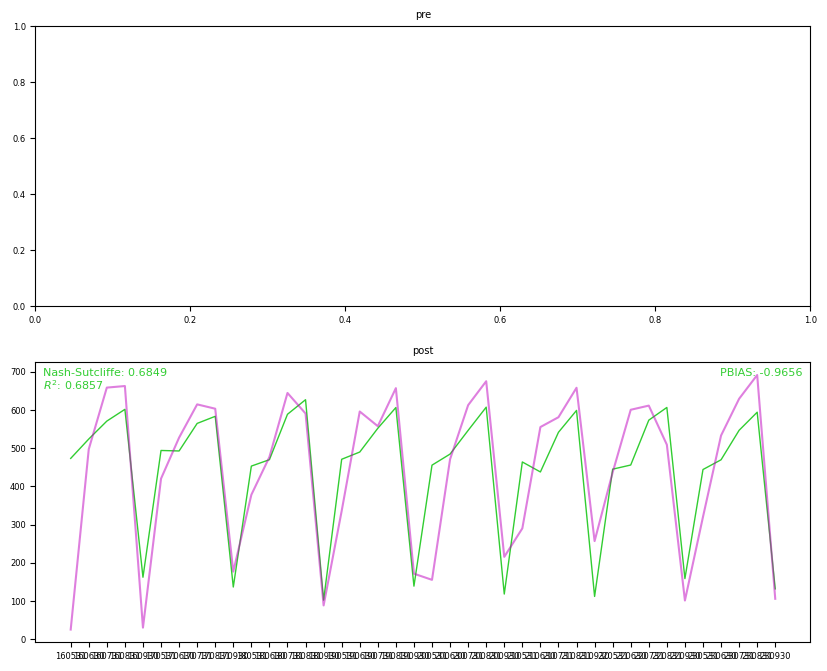

In [31]:
# plot progress comparison pre and post
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
# analyzer.plot_stf_sim_obd(axes[0], org_sim, dot=True)
analyzer.plot_stf_sim_obd(axes[1], stf_df, dot=False)
axes[0].set_title('pre')
axes[1].set_title('post')
plt.show()

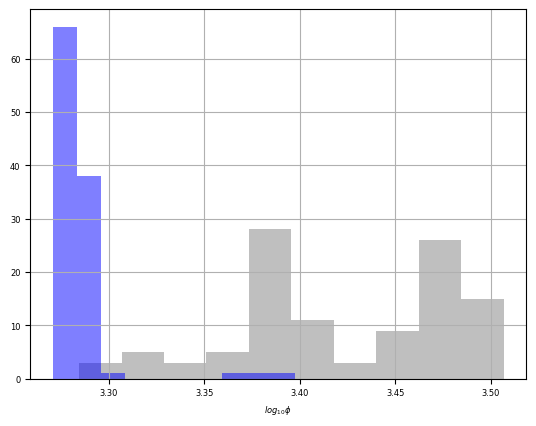

In [14]:
# plot progress
fig,ax = plt.subplots(1,1)
pr_oe.phi_vector.apply(np.log10).hist(ax=ax,fc="0.5",ec="none",alpha=0.5,density=False)
pt_oe.phi_vector.apply(np.log10).hist(ax=ax,fc="b",ec="none",alpha=0.5,density=False)
_ = ax.set_xlabel("$log_{10}\\phi$")

In [26]:
df = analyzer.get_pr_pt_df(pst, pr_oe, pt_oe)

return type uncaught, losing Ensemble type, returning DataFrame
return type uncaught, losing Ensemble type, returning DataFrame
return type uncaught, losing Ensemble type, returning DataFrame
return type uncaught, losing Ensemble type, returning DataFrame


D:\spark\spark_gits\swatp_pst_wf\dependencies\pyemu\pyemu\en.py:227: PyemuWarning: return type uncaught, losing Ensemble type, returning DataFrame
D:\spark\spark_gits\swatp_pst_wf\dependencies\pyemu\pyemu\en.py:227: PyemuWarning: return type uncaught, losing Ensemble type, returning DataFrame
D:\spark\spark_gits\swatp_pst_wf\dependencies\pyemu\pyemu\en.py:227: PyemuWarning: return type uncaught, losing Ensemble type, returning DataFrame
D:\spark\spark_gits\swatp_pst_wf\dependencies\pyemu\pyemu\en.py:227: PyemuWarning: return type uncaught, losing Ensemble type, returning DataFrame


KeyError: 'newtime'

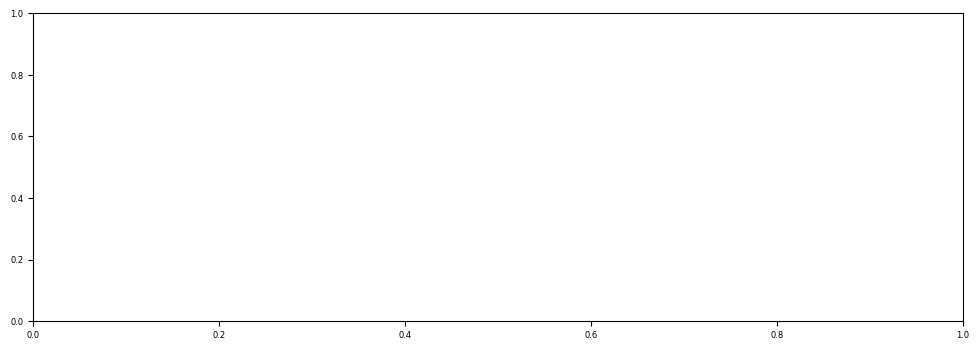

In [27]:
analyzer.plot_fill_between_ensembles(df)

In [15]:
# plot 1 to 1 scatter plot and residuals
pyemu.plot_utils.res_1to1(pst);

2024-08-21 08:15:11.865538 ERROR: res_phi_pie: pst.res is None, couldn't find residuals file


Exception: res_phi_pie: pst.res is None, couldn't find residuals file

## 03.02 Predictive uncertainty

In [ ]:
analyzer.single_plot_tseries_ensembles_plots_added(
    pst, pr_oe, pt_oe, width=10, height=5, dot=False,
    # bstcs=["56", "171"], 
    # orgsim=org_sim
)

## 03.03 Parameter uncertainty

In [16]:
prior_df = pyemu.ParameterEnsemble.from_csv(
    pst=pst,filename=os.path.join(m_d,"alb_rw_ies.{0}.par.csv".format(0)))
post_df = pyemu.ParameterEnsemble.from_csv(
    pst=pst,filename=os.path.join(m_d,"alb_rw_ies.{0}.par.csv".format(8)))

In [17]:
df_pars = pd.read_csv(os.path.join(m_d, "alb_rw_ies.par_data.csv"))
sel_pars = df_pars.loc[df_pars["partrans"]=='log']
sel_pars

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
0,alpha,log,factor,100,1,199,pargp,1,-100,1
1,awc,log,factor,100,1,199,pargp,1,-100,1
2,canmx,log,factor,100,1,199,pargp,1,-100,1
3,cn2,log,factor,100,1,199,pargp,1,-100,1
4,cn3_swf,log,factor,100,1,199,pargp,1,-100,1
5,epco,log,factor,100,1,199,pargp,1,-100,1
6,esco,log,factor,100,1,199,pargp,1,-100,1
7,lat_len,log,factor,100,1,199,pargp,1,-100,1
8,latq_co,log,factor,100,1,199,pargp,1,-100,1
9,perco,log,factor,100,1,199,pargp,1,-100,1


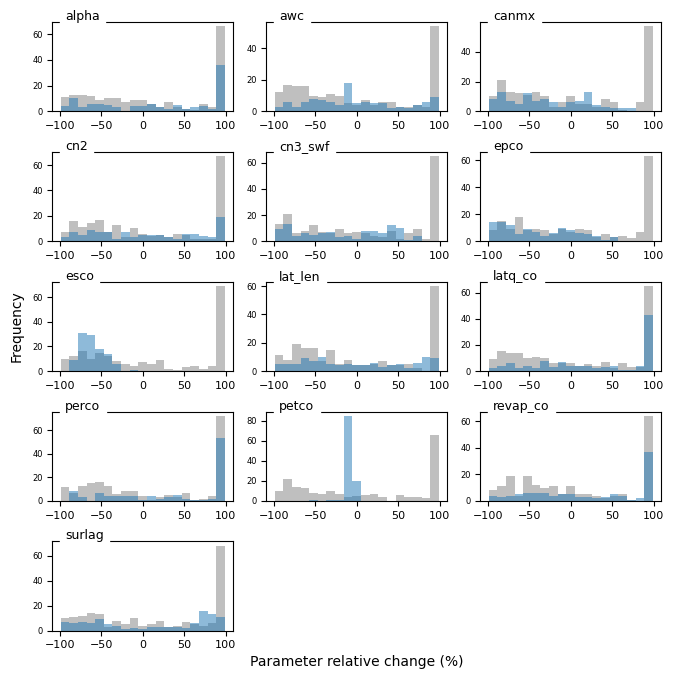

D:\spark\spark_gits\swatp_pst_wf\notebooks\02_workflows


In [34]:
analyzer.plot_prior_posterior_par_hist(m_d, pst, prior_df, post_df, sel_pars, height=7)

# 04 updates the model input files with parameter values

In [ ]:
m_d = "D:\\jj\\opt_3rd\\calibrated"
pst_file = "alb_rw_ies.pst"
pst = pyemu.Pst(os.path.join(m_d, pst_file))

In [ ]:
pst.parrep(parfile=os.path.join(m_d, "alb_rw_ies.{0}.base.par".format("final")))
# updates the model input files with parameter values
pst.write_input_files(pst_path=m_d)
# run the model forward run; this applies all the SWAT+ paarameters, executes SWAT+ 
os.chdir(m_d)
pyemu.os_utils.run('python forward_run.py')

In [ ]:
pyemu.os_utils.run("python forward_run.py",cwd=m_d)